In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

In [2]:
data=pd.read_csv('C://Users//Ansh Jhoshi//Downloads//1566806414_lesson_8_project//zinc_prices_IMF.csv')
data

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07
...,...,...
429,1-Oct-15,1724.34
430,1-Nov-15,1583.31
431,1-Dec-15,1527.79
432,1-Jan-16,1520.36


In [3]:
data.describe()

,Price
count,434.000000
mean,1362.338594
std,677.071321
min,597.450000
25%,875.355000
50%,1088.875000
75%,1742.052500
max,4381.450000


In [4]:
data.loc[:,'Date'] = pd.to_datetime(data['Date'])
data

,Date,Price
0,1980-01-01,773.82
1,1980-02-01,868.62
2,1980-03-01,740.75
3,1980-04-01,707.68
4,1980-05-01,701.07
...,...,...
429,2015-10-01,1724.34
430,2015-11-01,1583.31
431,2015-12-01,1527.79
432,2016-01-01,1520.36


In [5]:
data = data.set_index('Date')
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Date', length=434, freq=None)

In [6]:
ts = data['Price']

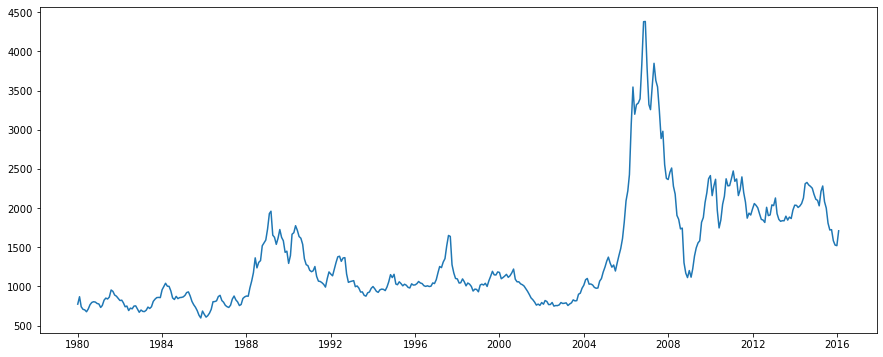

In [7]:
plt.plot(ts)

In [8]:
ts_log=np.log(ts)

In [9]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=12, center=False).mean()
    rolstd=timeseries.rolling(window=12, center=False).std()
    
    orig=plt.plot(timeseries, color='Blue', label='Original')
    mean=plt.plot(rolmean, color='red', label='Rolling Mean')
    std=plt.plot(rolstd, color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling mean and standard dev')
    plt.show(block = False)
    
    print('Result of dickey fuller test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags used','Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
    print(dfoutput)

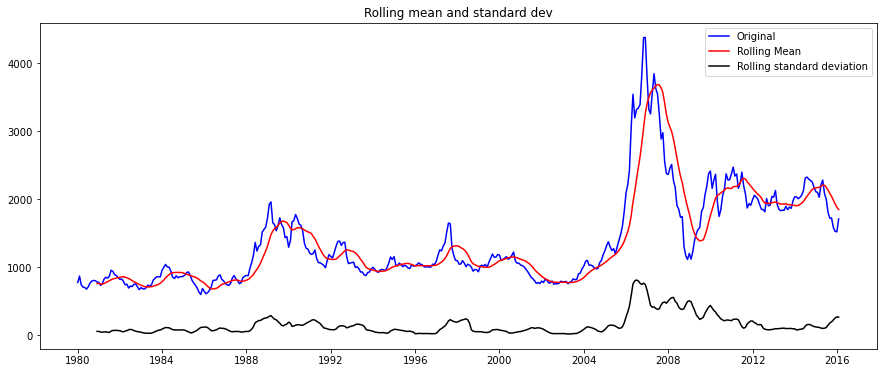

Result of dickey fuller test: 
Test Statistic                  -3.139601
p-value                          0.023758
#Lags used                       7.000000
Number of observations used    426.000000
Critical value (1%)             -3.445794
Critical value (5%)             -2.868349
Critical value (10%)            -2.570397
dtype: float64


In [10]:
test_stationarity(data['Price'])

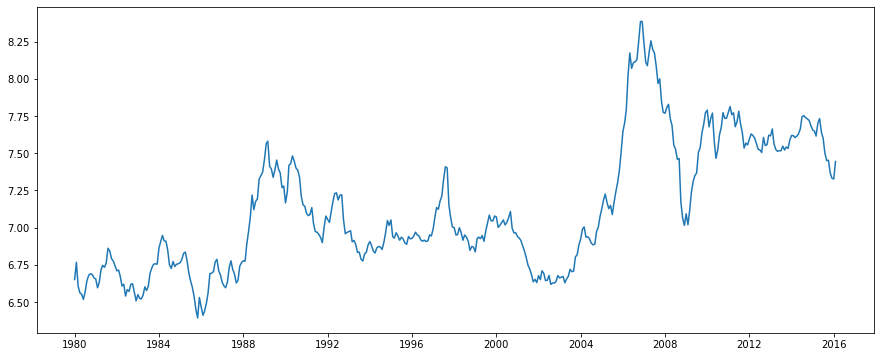

In [11]:
plt.plot(ts_log)

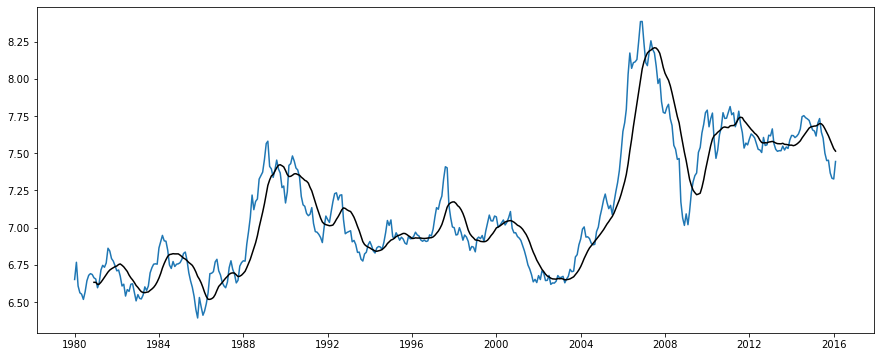

In [12]:
rolling_avg = ts_log.rolling(window = 12).mean()
rolling_Std = ts_log.rolling(window = 12).std()

plt.plot(ts_log)
plt.plot(rolling_avg, color='black')
plt.show()

In [13]:
ts_log_mv_diff = ts_log - rolling_avg

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Date
1980-12-01    0.030472
1981-01-01    0.021753
1981-02-01   -0.022485
1981-03-01    0.008392
1981-04-01    0.082191
1981-05-01    0.097617
1981-06-01    0.066587
1981-07-01    0.078914
1981-08-01    0.160180
1981-09-01    0.127928
Name: Price, dtype: float64

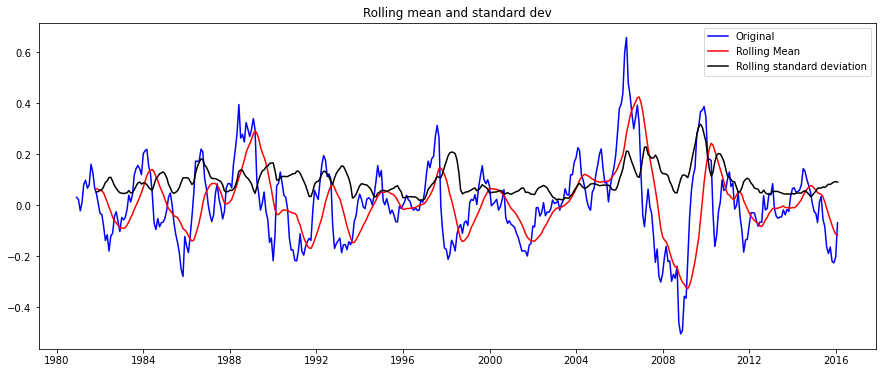

Result of dickey fuller test: 
Test Statistic                -5.898484e+00
p-value                        2.814411e-07
#Lags used                     4.000000e+00
Number of observations used    4.180000e+02
Critical value (1%)           -3.446091e+00
Critical value (5%)           -2.868479e+00
Critical value (10%)          -2.570466e+00
dtype: float64


In [14]:
test_stationarity(ts_log_mv_diff)

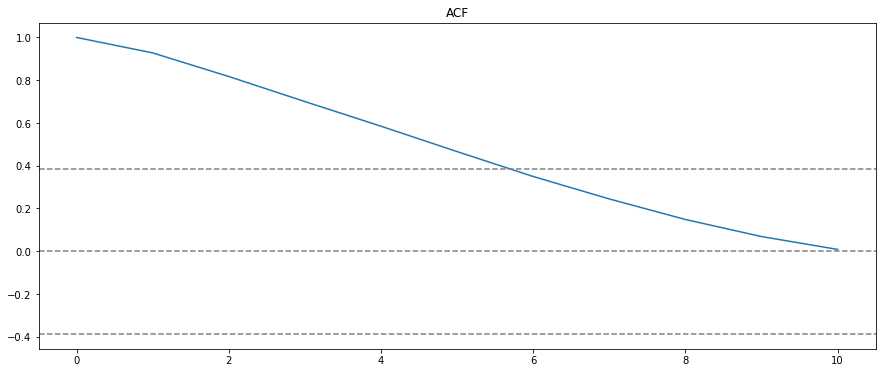

In [15]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')

plt.title('ACF')
plt.show()

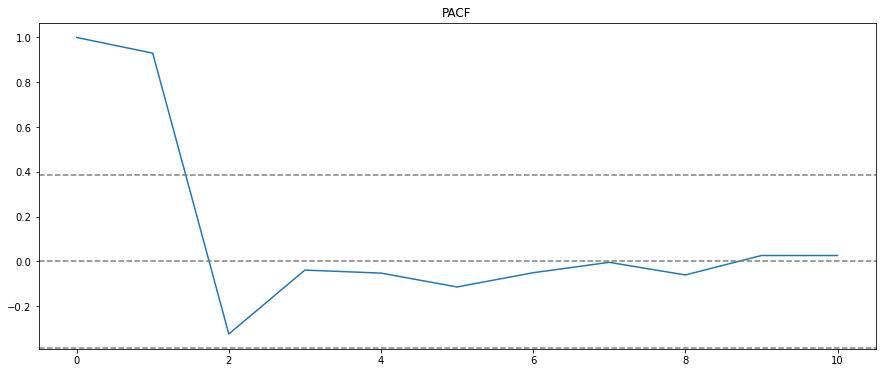

In [16]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')

plt.title('PACF')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

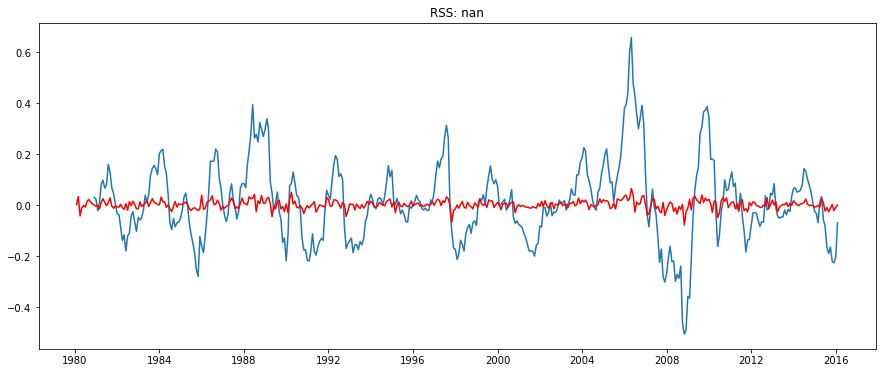

In [28]:
model=ARIMA(ts_log, order=(2,1,0))
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [29]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1980-02-01    0.002029
1980-03-01    0.033052
1980-04-01   -0.042391
1980-05-01   -0.010670
1980-06-01   -0.000989
dtype: float64

In [30]:
prediction_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
prediction_ARIMA_diff_cumsum.head()

Date
1980-02-01    0.002029
1980-03-01    0.035081
1980-04-01   -0.007310
1980-05-01   -0.017980
1980-06-01   -0.018969
dtype: float64

In [34]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(prediction_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1980-01-01    6.651339
1980-02-01    6.653369
1980-03-01    6.686420
1980-04-01    6.644029
1980-05-01    6.633359
dtype: float64

Text(0.5, 1.0, 'RMSE: 429.7812')

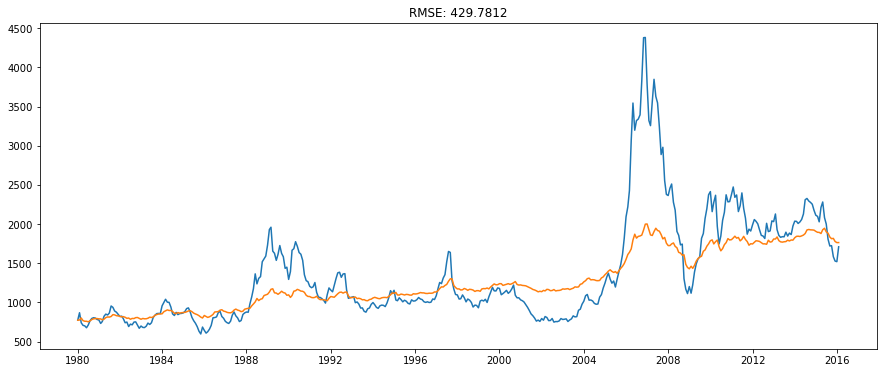

In [35]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))